### Predicting weekly sales at Walmart

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **linear regression model** (baseline)
- Part 3 : avoid overfitting by training a **regularized regression model**

#### Part 1: Data preprocessing and EDA

In [22]:
import pandas as pd
import numpy as np

In [23]:
dat = pd.read_csv("Walmart_Store_sales.csv")

In [24]:
dat.shape #quite a small dataset

(150, 8)

In [25]:
dat.describe(include='all') 
#there are some missing values

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


In [26]:
dat.head(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
6,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658
7,20.0,03-02-2012,2203523.20,0.0,39.93,3.617,213.023622,6.961
8,14.0,10-12-2010,2600519.26,0.0,30.54,3.109,NaN,NaN
9,3.0,NaN,418925.47,0.0,60.12,3.555,224.132020,6.833


In [27]:
dat.dtypes

Store           float64
Date             object
Weekly_Sales    float64
Holiday_Flag    float64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [28]:
#convert Date column to date format
dat['Date'] = pd.to_datetime(dat['Date'],format='%d-%m-%Y')

In [29]:
dat.isnull().sum() #check for missing values

Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

In [30]:
#univariate analysis
import plotly.express as px
features = ['Temperature','Fuel_Price','CPI','Unemployment','Store','Holiday_Flag']
for i in range(len(features)):
    fig = px.histogram(dat[features[i]],width=600, height=300,title=features[i])
    fig.show()

#some outliers in CPI and unemployment

#### Remove / impute missing values

In [31]:
#remove rows where Weekly_Sales is missing (dependent variable)
mask = (dat['Weekly_Sales'].isnull())
dat = dat.loc[-mask,:]

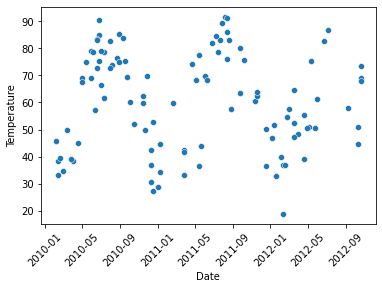

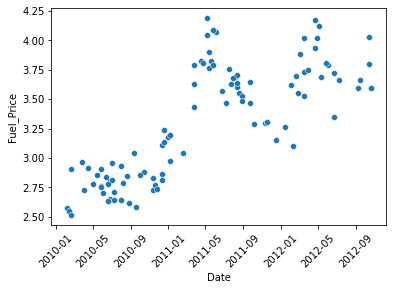

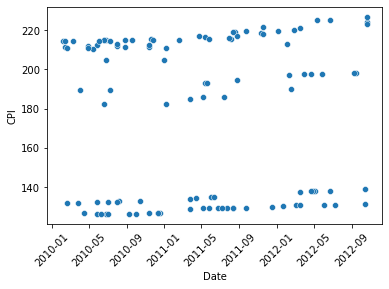

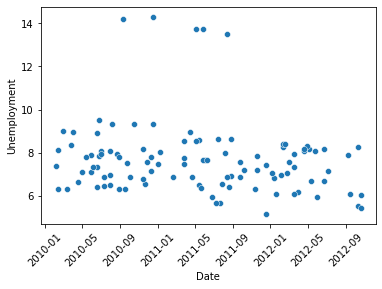

In [32]:
#for imputation - check if Temperature, Fuel Price, CPI and Unemployment depend on date. Assuming Holiday_Flag is date dependent
import seaborn as sns
import matplotlib.pyplot as plt

features = ['Temperature','Fuel_Price', 'CPI', 'Unemployment']

for i in features:
    sns.scatterplot(data=dat,x='Date',y=i)
    plt.xticks(rotation = 45)
    plt.show()

#Holiday_Flag, Temperature and Fuel Price seem to be date-dependent. Impute missing values with median on same date.

In [33]:
#impute values for Holiday_Flag manually

#see rows where Holiday_Flag is missing
dates = dat.loc[dat['Holiday_Flag'].isnull(),:]

#remove dates which are null
mask = dates['Date'].isnull()
dates = dates.loc[-mask,:]

#get list of Dates where Holiday_Flag is missing
date_list = list(dates['Date'])

#cross reference against other rows
dat.loc[dat['Date'].isin(date_list)].sort_values('Date') #looks like Holiday_Flag should be '0' for all dates except 3

#impute into main dataframe
#create list of dates for which Holiday_Flag should be '0'
date_list = ['2010-04-30', '2011-08-26','2011-03-25','2010-08-27','2010-07-09','2010-06-18']

#in main dataframe, impute '0' into Holiday_Flag if Date is in date_list
mask = (dat['Holiday_Flag'].isnull())&(dat['Date'].isin(date_list))
dat.loc[mask,'Holiday_Flag']=0

#update: i decided to assume it is not a holiday. impute all remaining missing values with '0'
dat.loc[dat['Holiday_Flag'].isnull(),'Holiday_Flag']=0

In [34]:
#impute temperature manually

#get list of dates that have missing Temperature values
date_list = dat.loc[dat['Temperature'].isnull(),:].sort_values('Date')
date_list = list(date_list.loc[-date_list['Date'].isnull(),'Date'])

#extract temperature on those dates from dat
temp = dat.loc[dat['Date'].isin(date_list),:].sort_values('Date')
temp = temp.loc[-temp['Temperature'].isna(),:].sort_values('Date')

#compute median temperature for each date
temp = temp.groupby('Date')['Temperature'].median()

#impute into main dataframe
dat.loc[dat['Temperature'].isna(),'Temperature']= dat['Date'].map(temp)

In [35]:
#impute fuel price manually

#get list of dates that have missing fuel_price values
date_list = dat.loc[dat['Fuel_Price'].isnull(),:].sort_values('Date')
date_list = list(date_list.loc[-date_list['Date'].isnull(),'Date'])

#extract fuel_price on those dates from dat
fuel = dat.loc[dat['Date'].isin(date_list),:].sort_values('Date')
fuel = fuel.loc[-fuel['Fuel_Price'].isna(),:].sort_values('Date')

#compute median fuel_price for each date
fuel = fuel.groupby('Date')['Fuel_Price'].median()

#impute into main dataframe
dat.loc[dat['Fuel_Price'].isna(),'Fuel_Price']= dat['Date'].map(fuel)

#### Remove useless columns

In [36]:
#remove Date column
dat.drop('Date',axis=1,inplace=True)
dat.shape

(136, 7)

#### Remove outliers

In [37]:
#remove outliers
features = ['Temperature', 'Fuel_Price','CPI', 'Unemployment']

outliers = pd.DataFrame([])

for i in features:
    mask = (dat[i]>(dat[i].mean() + 3*dat[i].std()))
    outlier = dat.loc[mask,:]
    outliers = outliers.append(outlier)


for i in features:
    mask = (dat[i]<(dat[i].mean() - 3*dat[i].std()))
    outlier = dat.loc[mask,:]
    outliers = outliers.append(outlier)

outliers

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
30,12.0,1021154.48,0.0,68.40,4.193,129.044433,13.736
62,12.0,1295605.35,0.0,52.77,3.236,126.879484,14.313
68,12.0,955913.68,0.0,91.04,3.701,129.201581,13.503
93,12.0,964332.51,0.0,NaN,4.087,129.062355,13.736
135,12.0,903119.03,1.0,83.63,3.044,126.114581,14.180


In [38]:
outlier_rows = list(outliers.index)
dat.drop(outlier_rows,axis=0,inplace=True)

In [39]:
outlier_rows

[30, 62, 68, 93, 135]

In [40]:
dat.shape

(131, 7)

In [41]:
dat.isnull().sum()

#how to treat remaining missing values
#Temperature - Impute with median
#Fuel_Price - Impute with median
#CPI - Impute with median
#Unemployment - Impute with median

Store            0
Weekly_Sales     0
Holiday_Flag     0
Temperature      7
Fuel_Price       7
CPI             11
Unemployment    14
dtype: int64

### Bivariate analysis
Test relationship w dependent variable and check for multicollinearity

In [407]:
#bivariate analysis to see if variables have a linear rship with the dependent variable
features = ['Temperature','Fuel_Price','CPI','Unemployment','Store','Holiday_Flag']

for i in features:
    fig = px.scatter(dat, y='Weekly_Sales',x=i,width=500, height=500,title=i)
    fig.show()

#CPI does not seem to have a linear relationship with weekly sales
#How to interpret categorical (ordinal) variables?

In [408]:
#bivariate analysis - I don't know how to interpret this chart
import plotly.graph_objects as go

fig = px.scatter_matrix(dat)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=800, width = 800)
fig.show()

In [409]:
#correlation matrix - not sure if this can be done with categorical variables (Holiday Flag, Store)
corr_matrix = dat.corr().round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

#weekly sales seems to be most correlated to CPI (-0.29) and Temperature (-0.17). I decided to go with Temperature for the baseline model as the CPI distribution seemed weird.
#there seems to be some collinearity between 
# - CPI and Store (-0.61)
# - CPI and Unemployment (-0.35)
# - Temperature and Store (-0.25) 

#### Train_test_split and create Column Transformer

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#### Linear regression (Baseline)

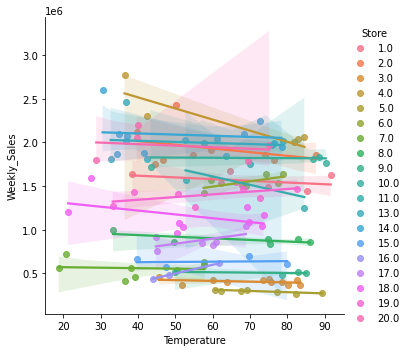

In [58]:
#tried to regress weekly_sales against temperature

sns.lmplot(data=dat, x='Temperature', y= 'Weekly_Sales', hue= 'Store')
plt.show()

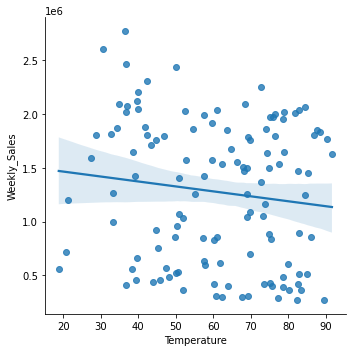

In [59]:
sns.lmplot(data=dat, x='Temperature', y= 'Weekly_Sales')
plt.show()

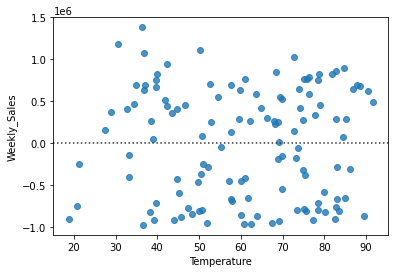

In [60]:
sns.residplot(data=dat, x='Temperature', y= 'Weekly_Sales')
plt.show()

In [61]:
#Separate target variable from explanatory variables
Y = dat.loc[:,'Weekly_Sales']
X= dat.loc[:,'Temperature']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

In [62]:
X_train = X_train.values.reshape(-1,1)
X_train = numeric_transformer.fit_transform(X_train)
X_test = X_test.values.reshape(-1,1)
X_test= numeric_transformer.transform(X_test)

#numeric_transformer did not work without converting X_train and X_test to np arrays and reshaping them.

In [63]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [65]:
print ("R2 score for train set: {}".format(model.score(X_train, Y_train)))
print ("R2 score for test set: {}".format(model.score(X_test, Y_test)))
model.coef_
#Results are terrible.

#FYI results for CPI: 
#R2 score for train set: 0.067776514028559
#R2 score for test set: 0.03084220305072871
#array([-171819.58505873])

R2 score for train set: 0.015299623574098087
R2 score for test set: -0.06425026601305595


array([-81634.44130108])

#### Linear regression (multi)

In [66]:
#Separate target variable from explanatory variables
Y = dat.loc[:,'Weekly_Sales']
X = dat.drop('Weekly_Sales',axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [67]:
X.columns

Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object')

In [68]:
# Create pipeline for numeric features
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'] # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = ['Store','Holiday_Flag'] # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [69]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [70]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [71]:
print ("R2 score for train set: {}".format(model.score(X_train, Y_train)))
print ("R2 score for test set: {}".format(model.score(X_test, Y_test)))

#Results are a lot better albeit with some overfitting

R2 score for train set: 0.96446447886486
R2 score for test set: 0.9445711679933543


In [72]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'x0_2.0', 'x0_3.0', 'x0_4.0', 'x0_5.0', 'x0_6.0', 'x0_7.0', 'x0_8.0', 'x0_9.0', 'x0_10.0', 'x0_11.0', 'x0_13.0', 'x0_14.0', 'x0_15.0', 'x0_16.0', 'x0_17.0', 'x0_18.0', 'x0_19.0', 'x0_20.0', 'x1_1.0']


In [73]:
coefs = pd.DataFrame(index = column_names, data = model.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
Temperature,-2.427761e+04
Fuel_Price,-5.251105e+04
CPI,9.642228e+04
Unemployment,-7.120713e+04
x0_2.0,3.852428e+05
x0_3.0,-1.204368e+06
x0_4.0,7.368469e+05
x0_5.0,-1.341849e+06
x0_6.0,-6.220985e+04
x0_7.0,-9.068870e+05


In [376]:
# Compute abs() and sort values
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance

#Comments 
# -how to tell strength of value that was dropped?

,coefficients
Temperature,2.427761e+04
x1_1.0,2.861325e+04
Fuel_Price,5.251105e+04
x0_11.0,6.106589e+04
x0_6.0,6.220985e+04
Unemployment,7.120713e+04
x0_19.0,9.413029e+04
CPI,9.642228e+04
x0_18.0,1.210696e+05
x0_2.0,3.852428e+05


#### Regularised regression (Ridge)

In [74]:
#use Gridsearch to find best alpha
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV

regressor = Ridge()
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

#It's strange that it is recommending no regularisation and the R2 score is still lower than the simple regression (0.92 vs 0.96 in the previous result)

Best hyperparameters :  {'alpha': 0.0}
Best R2 score :  0.9232565193217758


In [439]:
print("R2 score on training set : ", gridsearch.score(X_train, Y_train))
print("R2 score on test set : ", gridsearch.score(X_test, Y_test))

#For reference - R2 scores in previous result:
## R2 score for train set: 0.96446447886486
## R2 score for test set: 0.9445711679933543

#Not clear what's the difference between gridsearch.best_score_ and gridsearch.score

R2 score on training set :  0.9644624086833586
R2 score on test set :  0.9449150760002822


#### Regularised regression (Lasso)

In [441]:
#use Gridsearch to find best alpha
regressor = Lasso(max_iter=10e+5)
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)

print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 387082606944.036, tolerance: 3054609141.553844

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 432525077405.5063, tolerance: 2877585168.342598

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_val

Best hyperparameters :  {'alpha': 1.0}
Best R2 score :  0.9229865169421819


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 557517657857.8254, tolerance: 3031738977.7370577



In [443]:
gridsearch.best_estimator_.coef_

array([  -24277.27246365,   -52494.76114704,    96373.51571045,
         -71171.36284892,   385267.00344533, -1204294.37154955,
         736806.35460564, -1341748.11426626,   -62127.87989794,
        -906913.96166932,  -724664.03284758, -1192523.52097195,
         636248.87223177,    61048.16416999,   606314.83992759,
         655776.27076886,  -660935.69775529, -1070172.32544383,
        -530831.15656359,  -121146.73897923,    94025.40440399,
         406606.83618937,   -28558.88755437])

#### Conclusions

The non-regularised multivariate regression produced the best result as measured by the R2 score.
Does not match with expectations - expected the Ridge regression to do better given relatively small dataset (~130 rows) and large number of explanatory variables (23 not including the two that have been dropped)